## Install Required Libraries

In [1]:
!pip install transformers[torch] datasets seqeval accelerate -U


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DistilBertForTokenClassification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seqeval.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

c:\Users\dell g3\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a subset of the Universal Dependencies dataset for inspection
dataset = load_dataset("universal_dependencies", "en_gum")


In [4]:
# Print the column names for the training set
print(dataset['train'].column_names)
# Convert the 'train' split of your dataset to a Pandas DataFrame
train_df = dataset['train'].to_pandas()
print(train_df.head())
print(len(train_df))

['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc']
                  idx                                               text  \
0  GUM_academic_art-1            Aesthetic Appreciation and Spanish Art:   
1  GUM_academic_art-2                         Insights from Eye-Tracking   
2  GUM_academic_art-3  Claire Bailey-Ross claire.bailey-ross@port.ac....   
3  GUM_academic_art-4  Andrew Beresford a.m.beresford@durham.ac.uk Du...   
4  GUM_academic_art-5  Daniel Smith daniel.smith2@durham.ac.uk Durham...   

                                              tokens  \
0    [Aesthetic, Appreciation, and, Spanish, Art, :]   
1                     [Insights, from, Eye-Tracking]   
2  [Claire, Bailey-Ross, claire.bailey-ross@port....   
3  [Andrew, Beresford, a.m.beresford@durham.ac.uk...   
4  [Daniel, Smith, daniel.smith2@durham.ac.uk, Du...   

                                              lemmas  \
0    [aesthetic, appreciation, and, Spanish, art, :]   

In [5]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 29.0kB/s]
c:\Users\dell g3\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dell g3\.cache\huggingface\hub\models--distilbert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

In [6]:
unique_pos_tags = set()

# Aggregate unique POS tags from all dataset splits
for split in ['train', 'validation', 'test']:
    for example in dataset[split]:
        unique_pos_tags.update(example['upos'])

# Now that you have all unique POS tags, create the pos_tag2id and id2pos_tag dictionaries
pos_tag2id = {tag: idx for idx, tag in enumerate(unique_pos_tags)}
id2pos_tag = {idx: tag for tag, idx in pos_tag2id.items()}


In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", is_split_into_words=True, max_length=128)

    labels = [[] for _ in range(len(examples["tokens"]))]  # Initialize labels list for each example
    for i, label_sequence in enumerate(examples["upos"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Maps tokens to their word
        label_ids = [-100] * len(word_ids)  # Initialize all labels to ignore index

        previous_word_idx = None
        label_index = 0
        for word_idx in word_ids:
            if word_idx is not None and word_idx != previous_word_idx and label_index < len(label_sequence):
                label_id = pos_tag2id.get(label_sequence[label_index])  # Use .get() to avoid KeyError
                if label_id is not None:  # Check if the label_id exists
                    label_ids[word_idx] = label_id
                label_index += 1
            previous_word_idx = word_idx
        labels[i] = label_ids
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset['train'].column_names)
print(tokenized_datasets)
tokenized_datasets['train']
tokenized_datasets_df = tokenized_datasets['train'].to_pandas()
print(tokenized_datasets_df.head())
print(len(tokenized_datasets_df))

Map:   0%|          | 0/4287 [00:00<?, ? examples/s]

Map: 100%|██████████| 890/890 [00:00<00:00, 5254.32 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4287
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 784
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 890
    })
})
                                           input_ids  \
0  [101, 138, 13051, 13358, 11130, 73784, 74755, ...   
1  [101, 61862, 10107, 10188, 28577, 118, 26403, ...   
2  [101, 24448, 29761, 118, 16690, 103500, 10112,...   
3  [101, 13999, 40575, 62198, 169, 119, 181, 119,...   
4  [101, 11792, 11673, 10215, 19428, 119, 39709, ...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 

## Reduce the Dataset Size

Given the objective to explore the impact of partial layer freezing on POS tagging performance, starting with a reduced dataset can help quickly gauge the feasibility and potential direction of the research. Once promising configurations are identified,the task can be scaled up to the full dataset to fine-tune and validate the findings.

*   **Shuffling**: The datasets are shuffled before reduction to ensure that the reduced dataset is a representative random sample of the original. This is important for maintaining the diversity of examples in smaller datasets.
    
*   **Seed for Reproducibility**: The `seed=42` parameter in the `.shuffle()` method ensures that the shuffling process is reproducible, meaning you'll get the same reduced dataset if you run the code multiple times.
    
*   **Adjusting Reduction Percentage**: You can modify `reduced_percentage` to any value between 0 and 1 (exclusive) depending on how much you want to reduce the dataset by. A value of `0.5` reduces the dataset to half its original size, while `0.1` would reduce it to 10%, and so on.

In [9]:
from datasets import DatasetDict

reduced_percentage = 0.1  # Target percentage to reduce each dataset to

# Function to reduce dataset size by a specified percentage
def reduce_dataset_size(dataset, percentage):
    # Calculate the number of samples to select based on the reduction percentage
    num_samples = int(len(dataset) * percentage)
    # Shuffle the dataset (with a fixed seed for reproducibility) and select the first num_samples
    reduced_dataset = dataset.shuffle(seed=42).select(range(num_samples))
    return reduced_dataset

# Reduce the size of the training, validation, and test datasets
reduced_train_dataset = reduce_dataset_size(tokenized_datasets['train'], reduced_percentage)
reduced_validation_dataset = reduce_dataset_size(tokenized_datasets['validation'], reduced_percentage)
reduced_test_dataset = reduce_dataset_size(tokenized_datasets['test'], reduced_percentage)

# Create a new DatasetDict with the reduced datasets
reduced_tokenized_datasets = DatasetDict({
    'train': reduced_train_dataset,
    'validation': reduced_validation_dataset,
    'test': reduced_test_dataset
})

# Now, you can proceed with training and evaluation using `reduced_tokenized_datasets`
reduced_tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 428
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 78
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 89
    })
})

## Define the Compute Metrics

In [10]:
def compute_metrics(p):
    predictions, labels = p
    # Flatten both the predictions and labels for evaluation
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2pos_tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [id2pos_tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten the lists
    true_predictions = [p for sublist in true_predictions for p in sublist]
    true_labels = [l for sublist in true_labels for l in sublist]

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
    }


## Dataset Preparation and Baseline Model Training

In [12]:
# Assuming pos_tag2id has been defined based on your dataset's unique POS tags
num_labels = len(pos_tag2id)

model_baseline = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=num_labels
)

training_args_baseline = TrainingArguments(
    output_dir='./baseline_results',
    num_train_epochs=3,
    per_device_train_batch_size=128,  # Updated batch size
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer_baseline = Trainer(
    model=model_baseline,
    args=training_args_baseline,
    train_dataset=reduced_tokenized_datasets['train'],
    eval_dataset=reduced_tokenized_datasets['validation'],
    compute_metrics=compute_metrics  # Ensure this function computes accuracy, precision, recall, and F1
)

# Train the baseline model
trainer_baseline.train()

# Save the baseline model
trainer_baseline.save_model("./baseline_model")


model.safetensors: 100%|██████████| 542M/542M [01:04<00:00, 8.35MB/s] 
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [01:45<03:08, 23.56s/it]

{'loss': 2.7127, 'grad_norm': 1.5092084407806396, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


                                              
 33%|███▎      | 4/12 [01:53<03:08, 23.56s/it] 

{'eval_loss': 2.534414291381836, 'eval_precision': 0.040135669869983036, 'eval_recall': 0.06133902329359544, 'eval_f1': 0.023910133503189653, 'eval_accuracy': 0.19053051911009697, 'eval_runtime': 7.6576, 'eval_samples_per_second': 10.186, 'eval_steps_per_second': 1.306, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:48<01:42, 25.67s/it]

{'loss': 2.4788, 'grad_norm': 1.0170406103134155, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                              
 67%|██████▋   | 8/12 [03:55<01:42, 25.67s/it] 

{'eval_loss': 2.458814859390259, 'eval_precision': 0.03611142973498478, 'eval_recall': 0.06880594193542265, 'eval_f1': 0.03770750561567728, 'eval_accuracy': 0.2002281802624073, 'eval_runtime': 7.7464, 'eval_samples_per_second': 10.069, 'eval_steps_per_second': 1.291, 'epoch': 2.0}


100%|██████████| 12/12 [05:40<00:00, 24.14s/it]

{'loss': 2.4034, 'grad_norm': 1.0129964351654053, 'learning_rate': 0.0, 'epoch': 3.0}


                                               
100%|██████████| 12/12 [05:46<00:00, 24.14s/it]

{'eval_loss': 2.438114643096924, 'eval_precision': 0.0748533313937097, 'eval_recall': 0.073749851011053, 'eval_f1': 0.044792428413757863, 'eval_accuracy': 0.20365088419851682, 'eval_runtime': 6.6827, 'eval_samples_per_second': 11.672, 'eval_steps_per_second': 1.496, 'epoch': 3.0}


100%|██████████| 12/12 [05:56<00:00, 29.71s/it]


{'train_runtime': 356.5815, 'train_samples_per_second': 3.601, 'train_steps_per_second': 0.034, 'train_loss': 2.531620184580485, 'epoch': 3.0}


## Model Adjustment and Partial Freezing

In [16]:
def train_with_different_freezing_configs(freeze_configs, training_args, compute_metrics, train_dataset, eval_dataset):
    results = {}
    
    for config in freeze_configs:
        model_adjusted = initialize_and_freeze_model(layers_to_freeze=config)
        
        trainer = Trainer(
            model=model_adjusted,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics
        )

        config_name = "_".join(str(x) for x in config)  # Convert layer indices to a string
        print(f"Training with layers {config} frozen...")
        trainer.train()

        # Evaluate the model on the validation set
        eval_results = trainer.evaluate()
        results[f"Layers frozen: {config}"] = eval_results

        # Save the model for each configuration
        model_save_path = f"./models/model_layers_{config_name}_frozen"
        model_adjusted.save_pretrained(model_save_path)
        
        # Optionally, save the Trainer state as well
        trainer.save_state()

    return results


In [17]:
# Corrected function to initialize and freeze specified layers of the model
def initialize_and_freeze_model(layers_to_freeze):
    # Initialize the model
    model = DistilBertForTokenClassification.from_pretrained(
        'distilbert-base-multilingual-cased',
        num_labels=num_labels  # Ensure num_labels is defined correctly
    )

    # Freeze specified layers
    for name, param in model.named_parameters():
        # Freeze layers based on the provided list
        if any(f"transformer.layer.{i}." in name for i in layers_to_freeze):
            param.requires_grad = False

    return model

# Define different freezing configurations considering DistilBERT has 6 layers
freeze_configs = [
    [0],                # Freeze only the first layer
    [0, 1],             # Freeze the first two layers
    [0, 1, 2],          # Freeze the first three layers
    [0, 1, 2, 3],       # Freeze the first four layers
    [0, 1, 2, 3, 4],    # Freeze the first five layers
    [0, 1, 2, 3, 4, 5]  # Freeze all layers (for completeness of experiment)
]


# Proceed with the experiments
experiment_results = train_with_different_freezing_configs(
    freeze_configs=freeze_configs,
    training_args=training_args_baseline,
    compute_metrics=compute_metrics,
    train_dataset=reduced_tokenized_datasets['train'],
    eval_dataset=reduced_tokenized_datasets['validation']
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0] frozen...



 17%|█▋        | 2/12 [03:51<04:48, 28.82s/it]

{'loss': 2.7242, 'grad_norm': 1.6362910270690918, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}














                                         
                                              
 17%|█▋        | 2/12 [03:59<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5439460277557373, 'eval_precision': 0.07232232514092295, 'eval_recall': 0.06425808009638541, 'eval_f1': 0.035498534805695266, 'eval_accuracy': 0.18824871648602395, 'eval_runtime': 7.8122, 'eval_samples_per_second': 9.984, 'eval_steps_per_second': 1.28, 'epoch': 1.0}



 17%|█▋        | 2/12 [05:54<04:48, 28.82s/it]

{'loss': 2.4932, 'grad_norm': 1.1228306293487549, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}













                                           

                                               
 17%|█▋        | 2/12 [06:02<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.459272623062134, 'eval_precision': 0.09910206939793172, 'eval_recall': 0.07040431012361928, 'eval_f1': 0.04190813099942325, 'eval_accuracy': 0.20193953223046207, 'eval_runtime': 7.876, 'eval_samples_per_second': 9.903, 'eval_steps_per_second': 1.27, 'epoch': 2.0}



 17%|█▋        | 2/12 [07:51<04:48, 28.82s/it] 

{'loss': 2.4166, 'grad_norm': 1.1574232578277588, 'learning_rate': 0.0, 'epoch': 3.0}













                                            

                                               
 17%|█▋        | 2/12 [08:00<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4365015029907227, 'eval_precision': 0.1277376218552689, 'eval_recall': 0.07589225702768687, 'eval_f1': 0.049141724447015776, 'eval_accuracy': 0.20821448944666288, 'eval_runtime': 8.2136, 'eval_samples_per_second': 9.496, 'eval_steps_per_second': 1.217, 'epoch': 3.0}



100%|██████████| 12/12 [05:55<00:00, 29.62s/it]


{'train_runtime': 355.4272, 'train_samples_per_second': 3.613, 'train_steps_per_second': 0.034, 'train_loss': 2.5446723302205405, 'epoch': 3.0}


100%|██████████| 10/10 [00:07<00:00,  1.43it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1] frozen...



 17%|█▋        | 2/12 [09:50<04:48, 28.82s/it]

{'loss': 2.6893, 'grad_norm': 1.4679749011993408, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}













                                           

                                               
 17%|█▋        | 2/12 [09:57<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.54581356048584, 'eval_precision': 0.11086207639849797, 'eval_recall': 0.0651563655168822, 'eval_f1': 0.03586913712262081, 'eval_accuracy': 0.1876782658300057, 'eval_runtime': 7.249, 'eval_samples_per_second': 10.76, 'eval_steps_per_second': 1.379, 'epoch': 1.0}



 17%|█▋        | 2/12 [11:36<04:48, 28.82s/it]

{'loss': 2.4983, 'grad_norm': 1.134790062904358, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}













                                           

                                               
 17%|█▋        | 2/12 [11:44<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.467076063156128, 'eval_precision': 0.07514311406303598, 'eval_recall': 0.06643429871721543, 'eval_f1': 0.035471896789406925, 'eval_accuracy': 0.195094124358243, 'eval_runtime': 7.5971, 'eval_samples_per_second': 10.267, 'eval_steps_per_second': 1.316, 'epoch': 2.0}



 17%|█▋        | 2/12 [13:21<04:48, 28.82s/it] 

{'loss': 2.4244, 'grad_norm': 1.085565447807312, 'learning_rate': 0.0, 'epoch': 3.0}













                                            

                                               
 17%|█▋        | 2/12 [13:28<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4438469409942627, 'eval_precision': 0.08206694541753544, 'eval_recall': 0.07173085503249432, 'eval_f1': 0.04283320928335669, 'eval_accuracy': 0.20422133485453509, 'eval_runtime': 7.099, 'eval_samples_per_second': 10.987, 'eval_steps_per_second': 1.409, 'epoch': 3.0}



100%|██████████| 12/12 [05:19<00:00, 26.63s/it]


{'train_runtime': 319.5556, 'train_samples_per_second': 4.018, 'train_steps_per_second': 0.038, 'train_loss': 2.5373409589131675, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2] frozen...



 17%|█▋        | 2/12 [15:16<04:48, 28.82s/it]

{'loss': 2.703, 'grad_norm': 1.5147755146026611, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}













                                           

                                               
 17%|█▋        | 2/12 [15:24<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5697734355926514, 'eval_precision': 0.07895034661380605, 'eval_recall': 0.06430688495333214, 'eval_f1': 0.03632615090725487, 'eval_accuracy': 0.18254420992584142, 'eval_runtime': 7.7185, 'eval_samples_per_second': 10.106, 'eval_steps_per_second': 1.296, 'epoch': 1.0}



 17%|█▋        | 2/12 [17:07<04:48, 28.82s/it]

{'loss': 2.5266, 'grad_norm': 1.1499830484390259, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}













                                           

                                               
 17%|█▋        | 2/12 [17:15<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.490589141845703, 'eval_precision': 0.07902833141322255, 'eval_recall': 0.0658252387780009, 'eval_f1': 0.034020858496463365, 'eval_accuracy': 0.19452367370222476, 'eval_runtime': 8.2252, 'eval_samples_per_second': 9.483, 'eval_steps_per_second': 1.216, 'epoch': 2.0}



 17%|█▋        | 2/12 [18:54<04:48, 28.82s/it] 

{'loss': 2.4561, 'grad_norm': 1.0685828924179077, 'learning_rate': 0.0, 'epoch': 3.0}













                                            

                                               
 17%|█▋        | 2/12 [19:01<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4677038192749023, 'eval_precision': 0.08159911112714624, 'eval_recall': 0.06940131594646343, 'eval_f1': 0.04000013715498752, 'eval_accuracy': 0.20079863091842556, 'eval_runtime': 6.9895, 'eval_samples_per_second': 11.16, 'eval_steps_per_second': 1.431, 'epoch': 3.0}



100%|██████████| 12/12 [05:23<00:00, 26.92s/it]


{'train_runtime': 323.07, 'train_samples_per_second': 3.974, 'train_steps_per_second': 0.037, 'train_loss': 2.5619075298309326, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2, 3] frozen...



 17%|█▋        | 2/12 [20:43<04:48, 28.82s/it]

{'loss': 2.7241, 'grad_norm': 1.5354557037353516, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}














                                         
                                              
 17%|█▋        | 2/12 [20:51<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.6096155643463135, 'eval_precision': 0.06839387889608711, 'eval_recall': 0.0638686212879426, 'eval_f1': 0.03857427531328569, 'eval_accuracy': 0.1762692527096406, 'eval_runtime': 8.5796, 'eval_samples_per_second': 9.091, 'eval_steps_per_second': 1.166, 'epoch': 1.0}



 17%|█▋        | 2/12 [22:26<04:48, 28.82s/it]

{'loss': 2.5727, 'grad_norm': 1.2065348625183105, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}














                                         
                                              
 17%|█▋        | 2/12 [22:34<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5319695472717285, 'eval_precision': 0.10503247367940943, 'eval_recall': 0.06451434696603175, 'eval_f1': 0.03426126567959294, 'eval_accuracy': 0.18824871648602395, 'eval_runtime': 7.8652, 'eval_samples_per_second': 9.917, 'eval_steps_per_second': 1.271, 'epoch': 2.0}



 17%|█▋        | 2/12 [24:09<04:48, 28.82s/it] 

{'loss': 2.5065, 'grad_norm': 1.0569182634353638, 'learning_rate': 0.0, 'epoch': 3.0}














                                         
                                               
 17%|█▋        | 2/12 [24:17<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.509274482727051, 'eval_precision': 0.07721477479045882, 'eval_recall': 0.06487504797200873, 'eval_f1': 0.034105689221429314, 'eval_accuracy': 0.19110096976611524, 'eval_runtime': 7.3566, 'eval_samples_per_second': 10.603, 'eval_steps_per_second': 1.359, 'epoch': 3.0}



100%|██████████| 12/12 [05:05<00:00, 25.45s/it]


{'train_runtime': 305.3623, 'train_samples_per_second': 4.205, 'train_steps_per_second': 0.039, 'train_loss': 2.601102034250895, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2, 3, 4] frozen...



 17%|█▋        | 2/12 [25:58<04:48, 28.82s/it]

{'loss': 2.7578, 'grad_norm': 1.575357437133789, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}














                                         
                                              
 17%|█▋        | 2/12 [26:06<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.6804754734039307, 'eval_precision': 0.042480789107086685, 'eval_recall': 0.057401126004423736, 'eval_f1': 0.03754052751561802, 'eval_accuracy': 0.1477467199087279, 'eval_runtime': 7.307, 'eval_samples_per_second': 10.675, 'eval_steps_per_second': 1.369, 'epoch': 1.0}



 17%|█▋        | 2/12 [27:33<04:48, 28.82s/it]

{'loss': 2.6535, 'grad_norm': 1.3938895463943481, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}














                                         
                                              
 17%|█▋        | 2/12 [27:41<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.6170332431793213, 'eval_precision': 0.06300175955962121, 'eval_recall': 0.06329821429731708, 'eval_f1': 0.03924408276228973, 'eval_accuracy': 0.1728465487735311, 'eval_runtime': 7.4254, 'eval_samples_per_second': 10.504, 'eval_steps_per_second': 1.347, 'epoch': 2.0}



 17%|█▋        | 2/12 [29:12<04:48, 28.82s/it] 

{'loss': 2.5975, 'grad_norm': 1.2356091737747192, 'learning_rate': 0.0, 'epoch': 3.0}














                                         
                                               
 17%|█▋        | 2/12 [29:19<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.596062183380127, 'eval_precision': 0.0727432466320088, 'eval_recall': 0.06353179944264006, 'eval_f1': 0.037999036486297925, 'eval_accuracy': 0.17741015402167712, 'eval_runtime': 7.5619, 'eval_samples_per_second': 10.315, 'eval_steps_per_second': 1.322, 'epoch': 3.0}



100%|██████████| 12/12 [04:52<00:00, 24.38s/it]


{'train_runtime': 292.5097, 'train_samples_per_second': 4.39, 'train_steps_per_second': 0.041, 'train_loss': 2.6695982615152993, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2, 3, 4, 5] frozen...



 17%|█▋        | 2/12 [30:59<04:48, 28.82s/it]

{'loss': 2.808, 'grad_norm': 1.4173012971878052, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}














                                         
                                              
 17%|█▋        | 2/12 [31:07<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.7963616847991943, 'eval_precision': 0.06439936831267665, 'eval_recall': 0.07249836366003277, 'eval_f1': 0.05203079135225092, 'eval_accuracy': 0.10154021677124929, 'eval_runtime': 7.7464, 'eval_samples_per_second': 10.069, 'eval_steps_per_second': 1.291, 'epoch': 1.0}



 17%|█▋        | 2/12 [32:33<04:48, 28.82s/it]

{'loss': 2.7968, 'grad_norm': 1.4311739206314087, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}














                                         
                                              
 17%|█▋        | 2/12 [32:41<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.7853176593780518, 'eval_precision': 0.05971629058080164, 'eval_recall': 0.05523445425435447, 'eval_f1': 0.04807750393712648, 'eval_accuracy': 0.1026811180832858, 'eval_runtime': 7.5828, 'eval_samples_per_second': 10.286, 'eval_steps_per_second': 1.319, 'epoch': 2.0}



 17%|█▋        | 2/12 [34:07<04:48, 28.82s/it] 

{'loss': 2.78, 'grad_norm': 1.4085187911987305, 'learning_rate': 0.0, 'epoch': 3.0}














                                         
                                               
 17%|█▋        | 2/12 [34:14<04:48, 28.82s/it]
Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.7811477184295654, 'eval_precision': 0.059052109226723166, 'eval_recall': 0.055645421560985155, 'eval_f1': 0.04795498754106676, 'eval_accuracy': 0.1038220193953223, 'eval_runtime': 7.4313, 'eval_samples_per_second': 10.496, 'eval_steps_per_second': 1.346, 'epoch': 3.0}



100%|██████████| 12/12 [04:45<00:00, 23.76s/it]


{'train_runtime': 285.1839, 'train_samples_per_second': 4.502, 'train_steps_per_second': 0.042, 'train_loss': 2.7948994636535645, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


## Analysis and Comaprison

## Baseline Model

In [26]:
# # Evaluate base models on the test set to compare performance
baseline_results = trainer_baseline.evaluate(tokenized_datasets['test'])

print("Baseline Model Performance:", baseline_results)


































































































































































































































151it [02:12,  1.14it/s]

Baseline Model Performance: {'eval_loss': 2.386464834213257, 'eval_precision': 0.09407578285499864, 'eval_recall': 0.07821171108547773, 'eval_f1': 0.049397430715043884, 'eval_accuracy': 0.22077106618108752, 'eval_runtime': 87.0563, 'eval_samples_per_second': 10.223, 'eval_steps_per_second': 1.287, 'epoch': 3.0}


## Compounded Frozen Models


In [21]:
# Assuming num_labels, compute_metrics, training_args_baseline, and tokenized_datasets are defined

for config in freeze_configs:
    config_name = "_".join(str(x) for x in config)
    model_path = f"./models/model_layers_{config_name}_frozen"
    
    print(f"Loading and evaluating model with layers {config_name} frozen...")

    # Load the model
    model = DistilBertForTokenClassification.from_pretrained(model_path, num_labels=num_labels)
    
    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args_baseline,  # Assuming this is defined with the appropriate settings
        compute_metrics=compute_metrics,  # Ensure this is the function you've used previously
    )
    
    # Evaluate the model on the test set
    results = trainer.evaluate(tokenized_datasets['test'])
    
    # Print evaluation results for the current model configuration
    print(f"Results for {config_name}: {results}\n")
    
    # Store the results
    all_results[config_name] = results

Loading and evaluating model with layers 0 frozen...


































































































































































































































100%|██████████| 112/112 [01:23<00:00,  1.34it/s]


Results for 0: {'eval_loss': 2.402529716491699, 'eval_precision': 0.09381256020355845, 'eval_recall': 0.0771919823019609, 'eval_f1': 0.05012052393782567, 'eval_accuracy': 0.2234710536230064, 'eval_runtime': 84.0907, 'eval_samples_per_second': 10.584, 'eval_steps_per_second': 1.332}

Loading and evaluating model with layers 0_1 frozen...


































































































































































































































100%|██████████| 112/112 [01:22<00:00,  1.35it/s]


Results for 0_1: {'eval_loss': 2.406597852706909, 'eval_precision': 0.08942337598719528, 'eval_recall': 0.07338925260052032, 'eval_f1': 0.045050669465400206, 'eval_accuracy': 0.21712922265477835, 'eval_runtime': 83.5302, 'eval_samples_per_second': 10.655, 'eval_steps_per_second': 1.341}

Loading and evaluating model with layers 0_1_2 frozen...


































































































































































































































100%|██████████| 112/112 [01:10<00:00,  1.59it/s]


Results for 0_1_2: {'eval_loss': 2.4359045028686523, 'eval_precision': 0.0587861408808809, 'eval_recall': 0.06740266196745663, 'eval_f1': 0.03689643683128409, 'eval_accuracy': 0.20902926032902172, 'eval_runtime': 71.4477, 'eval_samples_per_second': 12.457, 'eval_steps_per_second': 1.568}

Loading and evaluating model with layers 0_1_2_3 frozen...


































































































































































































































100%|██████████| 112/112 [01:09<00:00,  1.60it/s]


Results for 0_1_2_3: {'eval_loss': 2.4841506481170654, 'eval_precision': 0.051193728821629585, 'eval_recall': 0.06299785649039669, 'eval_f1': 0.03209138683081588, 'eval_accuracy': 0.19910837624011052, 'eval_runtime': 70.522, 'eval_samples_per_second': 12.62, 'eval_steps_per_second': 1.588}

Loading and evaluating model with layers 0_1_2_3_4 frozen...


































































































































































































































100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


Results for 0_1_2_3_4: {'eval_loss': 2.580493688583374, 'eval_precision': 0.05502184967499687, 'eval_recall': 0.06151146113605829, 'eval_f1': 0.03668893207694418, 'eval_accuracy': 0.18246891874921511, 'eval_runtime': 71.7854, 'eval_samples_per_second': 12.398, 'eval_steps_per_second': 1.56}

Loading and evaluating model with layers 0_1_2_3_4_5 frozen...


































































































































































































































100%|██████████| 112/112 [01:24<00:00,  1.32it/s]

Results for 0_1_2_3_4_5: {'eval_loss': 2.777940034866333, 'eval_precision': 0.05076793585636581, 'eval_recall': 0.04786634363322587, 'eval_f1': 0.04297247566519718, 'eval_accuracy': 0.0997111641341203, 'eval_runtime': 85.4135, 'eval_samples_per_second': 10.42, 'eval_steps_per_second': 1.311}



## Visualizations

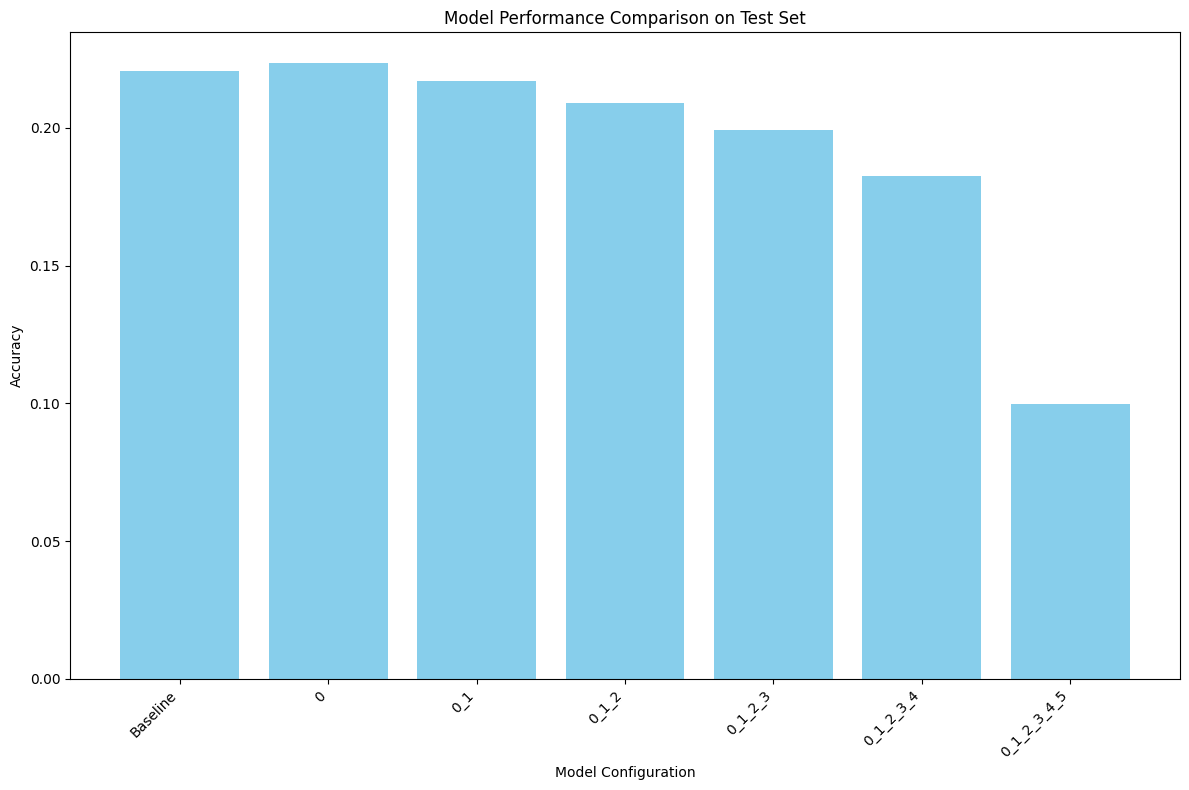

In [28]:

# For simplicity, let's plot the accuracy of each model configuration
accuracies = [baseline_results['eval_accuracy']] + [all_results[config]['eval_accuracy'] for config in all_results]
config_names = ['Baseline'] + list(all_results.keys())

plt.figure(figsize=(12, 8))
plt.bar(config_names, accuracies, color='skyblue')
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.title('Model Performance Comparison on Test Set')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()